0.5098064314260926
20121.216324634523
2.405193818498813


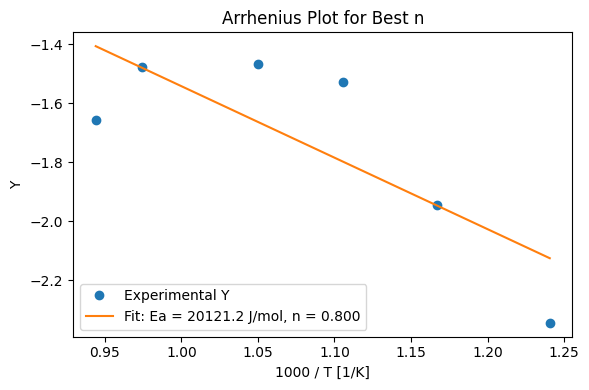

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

'''
I assume that the entire SMR reaction happens instantly and then we do WGS after. Not the most accurate prob. 
We could integrate along the reaction (setting up a dPCH4 and using that to solve through dPCO2) 
'''

# === INPUT DATA ===
dP_CO = 0.00001

Ptot = 3.15

tempss = np.array([532.8692303, 583.5779216, 631.2490162, 679.4119108, 753.4089858, 786.1913715])  # °C
T_data = tempss + 273.15  # K

ch4_ss = np.array([10.58967786, 9.100399715, 8.183042916, 6.427634432, 3.492847043, 1.427599783])
h2_ss = np.array([19.61424661, 24.35439391, 33.08009652, 40.18316061, 49.97503291, 56.3472753])
co_ss = np.array([0.0001429849477, 0.001020061582, 2.582607912, 4.370178284, 7.305258501, 9.710402925])
co2_ss = np.array([1.564520092, 2.374852411, 3.220787043, 3.444686712, 3.329101979, 2.928459987])
h2o_ss = np.array([47.61807528, 45.04543954, 34.72758843, 29.1242299 , 22.38286837, 18.13688983])

#inlet SCCM
SCCM_CH4_feed = 16.16
SCCM_H2_feed = 9
SCCM_CO_feed = 0
SCCM_CO2_feed = 0
SCCM_H20_feed = 43.04
SCCM_Ar_feed = 3.49

#before WGS
SCCM_CH4_in_data = ch4_ss
dCH4 = SCCM_CH4_feed - SCCM_CH4_in_data
SCCM_H2_in_data = SCCM_H2_feed + 3*dCH4
SCCM_CO_in_data = dCH4
SCCM_CO2_in = 0
SCCM_H2O_in_data = SCCM_H20_feed - dCH4

TotalSCCM = SCCM_CH4_in_data + SCCM_H2_in_data + SCCM_CO_in_data + SCCM_H2O_in_data + SCCM_CO2_in + SCCM_Ar_feed

P_CH4_in_data = Ptot * SCCM_CH4_in_data/TotalSCCM
P_H2_in_data = Ptot * SCCM_H2_in_data/TotalSCCM
P_CO_in_data = Ptot * SCCM_CO_in_data/TotalSCCM
P_CO2_in = 0
P_H2O_in_data = Ptot * SCCM_H2O_in_data/TotalSCCM
P_Ar_in_data = Ptot * SCCM_Ar_feed/TotalSCCM

P_CO2_out_Data = Ptot * co2_ss/(ch4_ss + h2_ss + co_ss + co2_ss + h2o_ss + SCCM_Ar_feed)

V_R = 2343.7 * 10**-9  # Reactor volume in m^3
total_flow = (16.16 + 9 + 43.04 + 3.49)/60000000 #m^3/s
S_V = total_flow/V_R  # 1/sec
print(S_V)
R = 8.314  # J/mol/K

# === EQUILIBRIUM CONSTANT FUNCTION ===
def K_eq(T):
    return np.exp(4400/T - 4.036)

# === INTEGRAL FUNCTION ===
def integral_I(n, T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in):
    sum = 0
    #adjust these to get the data when you are done
    P_CH4 = P_CH4_in
    P_CO2 = P_CO2_in
    P_H2O = P_H2O_in
    P_H2 = P_H2_in
    P_CO = P_CO_in
    P_Ar = P_Ar_in

    while P_CO2 < P_CO2_out:
        sum = sum + dP_CO/((P_CO**n) * (P_H2O**n) - 1/(K_eq(T)) * (P_CO2**n) * (P_H2**n))
        P_CO2 = P_CO2 + dP_CO
        P_H2O = P_H2O - dP_CO
        P_H2 = P_H2 + dP_CO
        P_CO = P_CO - dP_CO

        #pressure normalization 
        Ptotnew = P_CH4 + P_CO2 + P_H2O + P_H2 + P_CO + P_Ar
        P_CH4 = P_CH4*Ptot/Ptotnew
        P_CO2 = P_CO2*Ptot/Ptotnew
        P_H2O = P_H2O*Ptot/Ptotnew
        P_H2 = P_H2*Ptot/Ptotnew
        P_CO = P_CO*Ptot/Ptotnew
        P_Ar = P_Ar*Ptot/Ptotnew
    return sum

# === SCAN n VALUES AND FIT ===
n_range = np.linspace(0.8, 2.05, 50)
results = []

for n in n_range:
    I_n = np.array([integral_I(n, T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in)
                    for T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in in 
                    zip(T_data, P_CO2_out_Data, P_H2O_in_data, P_CO_in_data, P_H2_in_data, P_CH4_in_data, P_Ar_in_data)])
    expY = (S_V * I_n)
    Y = np.log(expY)
    inv_T = 1 / T_data
    slope, intercept, r_value, _, _ = linregress(inv_T, Y)
    Ea = -slope * R
    results.append({
        'n': n,
        'Ea_Jmol': Ea,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2
    })

# === SELECT BEST n ===
best_result = max(results, key=lambda d: d['r_squared'])
best_n = best_result['n']
best_slope = best_result['slope']
best_intercept = best_result['intercept']
best_Ea = best_result['Ea_Jmol']
print(best_Ea)
print(np.exp(best_intercept))

# === PLOT BEST FIT ===
I_best = np.array([integral_I(best_n, T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in)
                    for T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in in 
                    zip(T_data, P_CO2_out_Data, P_H2O_in_data, P_CO_in_data, P_H2_in_data, P_CH4_in_data, P_Ar_in_data)])
expY_best = (S_V * I_best)
Y_best = np.log(expY_best)
inv_T = 1 / T_data
Y_fit = best_slope * inv_T + best_intercept

plt.figure(figsize=(6, 4))
plt.plot(inv_T*1000, Y_best, 'o', label='Experimental Y')
plt.plot(inv_T*1000, Y_fit, '-', label=f'Fit: Ea = {best_Ea:.1f} J/mol, n = {best_n:.3f}')
plt.xlabel('1000 / T [1/K]')
plt.ylabel('Y')
plt.title('Arrhenius Plot for Best n')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()